<a href="https://colab.research.google.com/github/NickOsipov/notebooks/blob/main/metrics_ci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Пожалуйста, делайте копию на свой Google Drive!

# Доверительный интервал для метрик модели

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

In [1]:
from sklearn.datasets import load_breast_cancer

df = load_breast_cancer()

X = df["data"]
y = df["target"]

In [2]:
X

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

Распределение таргета

In [3]:
len(X)

569

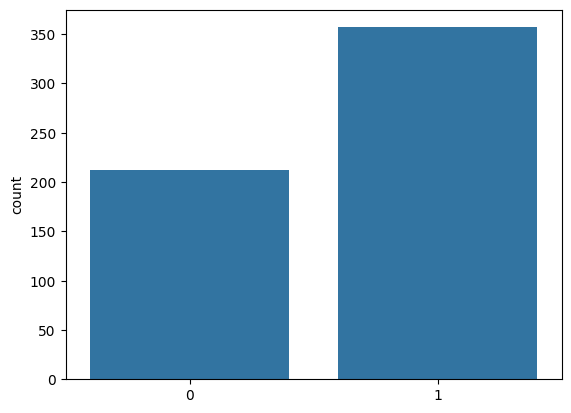

In [4]:
import seaborn as sns

sns.countplot(x=y);

Разделим выборку

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
len(X_train), len(X_test)

(398, 171)

Обучим пайплайн

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression()),
])

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

Bootstrap

In [8]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, roc_auc_score

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

bootstrap_iterations = 1000

acc_scores = np.zeros(bootstrap_iterations)
roc_auc_scores = np.zeros(bootstrap_iterations)


df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "y_pred_proba": y_pred_proba,
})


In [9]:
df.shape[0]

171

In [10]:
for i in range(bootstrap_iterations):
    sample = df.sample(frac=1, replace=True)
    acc_scores[i] = accuracy_score(sample.y_true, sample.y_pred)
    roc_auc_scores[i] = roc_auc_score(sample.y_true, sample.y_pred_proba)

In [11]:
sample.reset_index().sort_values("index")

,index,y_true,y_pred,y_pred_proba
48,1,0,0,0.000015
49,1,0,0,0.000015
91,1,0,0,0.000015
24,3,1,1,0.999449
20,4,1,1,0.999913
...,...,...,...,...
83,167,1,1,0.670462
111,167,1,1,0.670462
137,167,1,1,0.670462
123,167,1,1,0.670462


In [12]:
len(acc_scores), len(roc_auc_scores)

(1000, 1000)

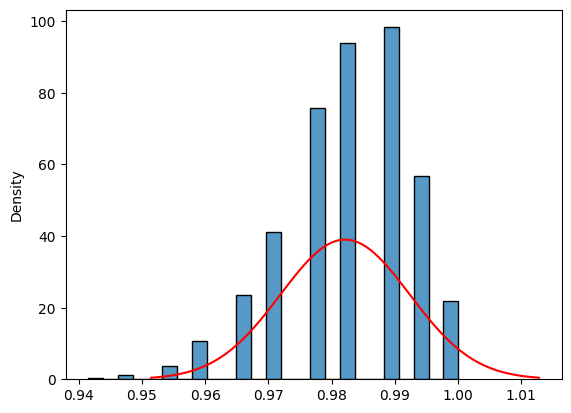

In [13]:
from scipy.stats import norm

acc_mean = acc_scores.mean()
acc_std = acc_scores.std()

acc_low = acc_mean - 3 * acc_std
acc_upp = acc_mean + 3 * acc_std

ax = sns.histplot(acc_scores, stat="density")
x = np.linspace(acc_low, acc_upp, 100)
ax.plot(x, norm.pdf(x, loc=acc_mean, scale=acc_std), color="red");

In [14]:
x

array([0.95146547, 0.95208505, 0.95270463, 0.9533242 , 0.95394378,
       0.95456335, 0.95518293, 0.95580251, 0.95642208, 0.95704166,
       0.95766124, 0.95828081, 0.95890039, 0.95951997, 0.96013954,
       0.96075912, 0.96137869, 0.96199827, 0.96261785, 0.96323742,
       0.963857  , 0.96447658, 0.96509615, 0.96571573, 0.96633531,
       0.96695488, 0.96757446, 0.96819403, 0.96881361, 0.96943319,
       0.97005276, 0.97067234, 0.97129192, 0.97191149, 0.97253107,
       0.97315065, 0.97377022, 0.9743898 , 0.97500937, 0.97562895,
       0.97624853, 0.9768681 , 0.97748768, 0.97810726, 0.97872683,
       0.97934641, 0.97996599, 0.98058556, 0.98120514, 0.98182471,
       0.98244429, 0.98306387, 0.98368344, 0.98430302, 0.9849226 ,
       0.98554217, 0.98616175, 0.98678133, 0.9874009 , 0.98802048,
       0.98864005, 0.98925963, 0.98987921, 0.99049878, 0.99111836,
       0.99173794, 0.99235751, 0.99297709, 0.99359667, 0.99421624,
       0.99483582, 0.99545539, 0.99607497, 0.99669455, 0.99731

In [15]:
acc_mean

np.float64(0.9821345029239764)

In [16]:
print(f"Model accuracy CI: ({acc_low:.3}, {acc_upp:.3})")

Model accuracy CI: (0.951, 1.01)


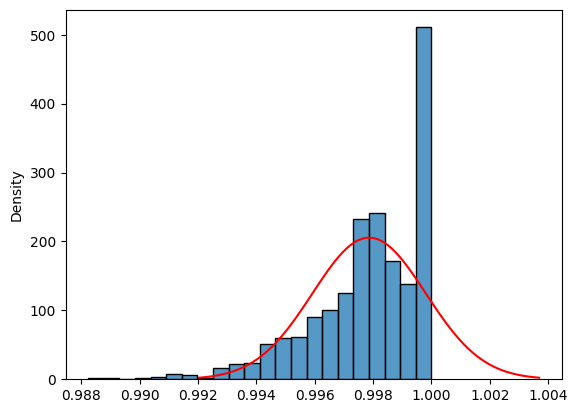

In [17]:
roc_auc_mean = roc_auc_scores.mean()
roc_auc_std = roc_auc_scores.std()

roc_auc_low = roc_auc_mean - 3 * roc_auc_std
roc_auc_upp = roc_auc_mean + 3 * roc_auc_std

ax = sns.histplot(roc_auc_scores, stat="density")
x = np.linspace(roc_auc_low, roc_auc_upp, 100)
ax.plot(x, norm.pdf(x, loc=roc_auc_mean, scale=roc_auc_std), color="red");

In [18]:
roc_auc_mean

np.float64(0.9978673983625267)

In [19]:
print(f"Model ROC-AUC CI: ({roc_auc_low:.3}, {roc_auc_upp:.3})")

Model ROC-AUC CI: (0.992, 1.0)
